In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import nltk
import os
import re
import pickle
import sklearn
import sys
import string
import joblib

from scipy.spatial.distance import cosine

from sklearn.metrics import f1_score, precision_score, recall_score,average_precision_score
from sklearn.model_selection import cross_val_score, GridSearchCV,ParameterGrid, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import LatentDirichletAllocation

from tqdm import *

%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

In [3]:
%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics,src.utils.plotting

In [4]:
from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking
from src.utils.plotting import plot_micro_f1_at_k

In [5]:
MODELS_ROOT = os.path.abspath("../../../models/ranking/movielens-svm-tf-idf-lda/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-20.csv')

# CONFIGS
SEED= 42

In [6]:
np.random.seed(SEED)

In [7]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)

In [8]:
labels = docs_df["tags"].map(lambda tagstring: tagstring.split(","))

In [9]:
mlb = MultiLabelBinarizer()

binary_labels = mlb.fit_transform(labels)

print("total number of unique tags: {} ".format(len(mlb.classes_)))

data = docs_df['synopsis'].values
indices = np.arange(len(data))

np.random.shuffle(indices)

data = [data[i] for i in indices]
targets = binary_labels[indices]
num_validation_samples = int(0.15 * len(data))

X_train = data[:-num_validation_samples]
Y_train = targets[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = targets[-num_validation_samples:]

print('total number of train documents: {}'.format(len(X_train)))
print('total number of validation documents: {}'.format(len(X_val)))

total number of unique tags: 2138 
total number of train documents: 5704
total number of validation documents: 1006


In [ ]:
# # https://github.com/scikit-learn/scikit-learn/issues/6614
# class MyTfidfVectorizer(TfidfVectorizer):
#     def fit_transform(self, X, y):
#         result = super(MyTfidfVectorizer, self).fit_transform(X, y)
#         result.sort_indices()
#         return result

In [16]:
parameters = [
    { 
        "vect__max_features": [500],
        "vect__norm": ['l1','l2',None],
        "lda__n_components":[5,10,50,100],
        "svm__kernel":["rbf","linear"]
    },
    {
        "vect__max_features": [500],
        "vect__norm": ['l1','l2',None],
        "lda__n_components":[5,10,50,100],
        "svm__kernel":["poly"],
        "svm__degree":[2,3,4,5]
    }
]

In [17]:
len(ParameterGrid(parameters))

72

In [19]:
for g in ParameterGrid(parameters):
    print(g)
    vect=TfidfVectorizer().set_params(**dict([(re.sub('^vect__','',k),v) for (k,v) in g.items() if k.startswith('vect__') ]))
    vect.fit(X_train)
    
    X_train_vect = vect.transform(X_train)
    X_val_vect = vect.transform(X_val)
    
    number_of_components = g['lda__n_components']
    
    # cache the lda model because it's expensive to build
    if os.path.isfile(MODELS_ROOT+"/lda-{}.p".format(number_of_components)):
        lda=joblib.load(open(MODELS_ROOT+"/lda-{}.p".format(number_of_components),"rb"))
    else:
        print('calculating LDA model for {} components'.format(number_of_components))
        lda = LatentDirichletAllocation(n_components=number_of_components, learning_method='online')
        lda.fit(X_train_vect)
        joblib.dump(lda,open(MODELS_ROOT+"/lda-{}.p".format(number_of_components),"wb"))

    # these are the topic distributions
    X_train_vect = lda.transform(X_train_vect)
    X_val_vect = lda.transform(X_val_vect)
    
    svm = SVC().set_params(**dict([(re.sub('^svm__','',k),v) for (k,v) in g.items() if k.startswith('svm__') ]))
    
    clf = OneVsRestClassifier(CalibratedClassifierCV(svm,cv=2),n_jobs=-1)
    clf.fit(X_train_vect,Y_train)

    Y_pred_val = clf.predict_proba(X_val_vect)
                  
    ks = [1,2,3,4,5,6,7,8,9,10]
        
    # k is the number of neighbors so let's use at_k
    for at_k in ks:
        print("validation micro-F1 @{}: {}".format(at_k,ranking.micro_f1_at_k(Y_val,Y_pred_val,k=at_k,normalize=True))) 
        
    print('')    

{'vect__norm': 'l1', 'svm__kernel': 'rbf', 'lda__n_components': 5, 'vect__max_features': 500}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect__norm': 'l2', 'svm__kernel': 'rbf', 'lda__n_components': 5, 'vect__max_features': 500}
validation micro-F1 @1: 0.23043095866314864
validation micro-F1 @2: 0.2003577817531306
validation micro-F1 @3: 0.19227313566936208
validation micro-F1 @4: 0.18575293056807934
validation micro-F1 @5: 0.17852616331703783
validation micro-F1 @6: 0.1717401181281236
validation micro-F1 @7: 0.16924476797088261
validation micro-F1 @8: 0.1646522234891676
validation micro-F1 @9: 

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])


validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.2091677792612372
validation micro-F1 @3: 0.19389587073608616
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18214672930972173
validation micro-F1 @6: 0.1717401181281236
validation micro-F1 @7: 0.16757741347905283
validation micro-F1 @8: 0.16507067943456452
validation micro-F1 @9: 0.16199756394640683
validation micro-F1 @10: 0.16222141030325174

{'vect__norm': 'l1', 'svm__kernel': 'linear', 'lda__n_components': 5, 'vect__max_features': 500}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect__norm': 'l2', 'svm

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:510: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(self.a_ * T + self.b_))


validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20677361853832443
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.18820351193156237
validation micro-F1 @5: 0.18017366136034732
validation micro-F1 @6: 0.17505668934240362
validation micro-F1 @7: 0.16924476797088261
validation micro-F1 @8: 0.16632490316700843
validation micro-F1 @9: 0.16386128574325695
validation micro-F1 @10: 0.16087751371115175

{'vect__norm': 'l1', 'svm__kernel': 'linear', 'lda__n_components': 10, 'vect__max_features': 500}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect__norm': 'l2', '

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:510: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(self.a_ * T + self.b_))


validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.19308486753480017
validation micro-F1 @3: 0.18684289576449384
validation micro-F1 @4: 0.18165386353366472
validation micro-F1 @5: 0.17323406573451972
validation micro-F1 @6: 0.17229371688115064
validation micro-F1 @7: 0.17328145265888456
validation micro-F1 @8: 0.16903651461722216
validation micro-F1 @9: 0.16423357664233576
validation micro-F1 @10: 0.16188562031792436

{'vect__norm': 'l1', 'svm__kernel': 'linear', 'lda__n_components': 100, 'vect__max_features': 500}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect__norm': 'l2',

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])


validation micro-F1 @1: 0.23043095866314864
validation micro-F1 @2: 0.2091677792612372
validation micro-F1 @3: 0.19874664279319607
validation micro-F1 @4: 0.18983355825461087
validation micro-F1 @5: 0.18083182640144665
validation micro-F1 @6: 0.1747807680677351
validation micro-F1 @7: 0.16972059779077323
validation micro-F1 @8: 0.16360524814603536
validation micro-F1 @9: 0.16255707762557078
validation micro-F1 @10: 0.15936327874851342

{'vect__norm': 'l1', 'vect__max_features': 500, 'svm__degree': 3, 'lda__n_components': 5, 'svm__kernel': 'poly'}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect__

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])


validation micro-F1 @1: 0.22731277533039648
validation micro-F1 @2: 0.20357142857142857
validation micro-F1 @3: 0.18847539015606243
validation micro-F1 @4: 0.1869790493354359
validation micro-F1 @5: 0.17720601558253307
validation micro-F1 @6: 0.17229371688115064
validation micro-F1 @7: 0.16686190290251204
validation micro-F1 @8: 0.16527983586002506
validation micro-F1 @9: 0.16106428353813343
validation micro-F1 @10: 0.15902644340744806

{'vect__norm': 'l1', 'vect__max_features': 500, 'svm__degree': 2, 'lda__n_components': 10, 'svm__kernel': 'poly'}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])


validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20116227089852481
validation micro-F1 @3: 0.19281437125748502
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18148951554591466
validation micro-F1 @6: 0.17505668934240362
validation micro-F1 @7: 0.1659070191431176
validation micro-F1 @8: 0.16444292393659482
validation micro-F1 @9: 0.16255707762557078
validation micro-F1 @10: 0.15953165020124405

{'vect__norm': 'l1', 'vect__max_features': 500, 'svm__degree': 5, 'lda__n_components': 10, 'svm__kernel': 'poly'}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect_

/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])


validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.2003577817531306
validation micro-F1 @3: 0.1895620875824835
validation micro-F1 @4: 0.18288552720704448
validation micro-F1 @5: 0.17819630568634554
validation micro-F1 @6: 0.17201695941853423
validation micro-F1 @7: 0.16757741347905283
validation micro-F1 @8: 0.16255707762557078
validation micro-F1 @9: 0.1616243654822335
validation micro-F1 @10: 0.15936327874851342

{'vect__norm': None, 'vect__max_features': 500, 'svm__degree': 2, 'lda__n_components': 50, 'svm__kernel': 'poly'}


/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435

validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.19955257270693513
validation micro-F1 @3: 0.19010494752623688
validation micro-F1 @4: 0.18779554154469713
validation micro-F1 @5: 0.17984440021711598
validation micro-F1 @6: 0.17201695941853423
validation micro-F1 @7: 0.16829236571725842
validation micro-F1 @8: 0.16632490316700843
validation micro-F1 @9: 0.16348884381338744
validation micro-F1 @10: 0.16020482809070957

{'vect__norm': 'l1', 'vect__max_features': 500, 'svm__degree': 3, 'lda__n_components': 50, 'svm__kernel': 'poly'}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vec

validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect__norm': 'l1', 'vect__max_features': 500, 'svm__degree': 4, 'lda__n_components': 100, 'svm__kernel': 'poly'}
validation micro-F1 @1: 0.23353819139596138
validation micro-F1 @2: 0.20517395182872436
validation micro-F1 @3: 0.1971326164874552
validation micro-F1 @4: 0.1873873873873874
validation micro-F1 @5: 0.18247515808491419
validation micro-F1 @6: 0.17615954071612025
validation micro-F1 @7: 0.1651902032308494
validation micro-F1 @8: 0.16024688535832668
validation micro-F1 @9: 0.15882053889171327
validation micro-F1 @10: 0.15852095917993778

{'vect_

## plot the victorious model

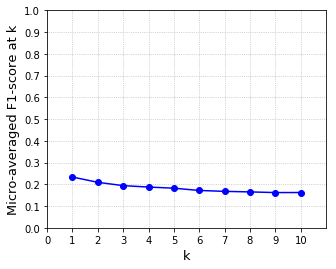

In [20]:
plt.clf()
ax = plt.gca()

# {'vect__norm': None, 'svm__kernel': 'rbf', 'lda__n_components': 5, 'vect__max_features': 500}
# /home/felipe/tf-venv3/lib/python3.5/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
#   E = np.exp(AB[0] * F + AB[1])
# validation micro-F1 @1: 0.23353819139596138
# validation micro-F1 @2: 0.2091677792612372
# validation micro-F1 @3: 0.19389587073608616
# validation micro-F1 @4: 0.1873873873873874
# validation micro-F1 @5: 0.18214672930972173
# validation micro-F1 @6: 0.1717401181281236
# validation micro-F1 @7: 0.16757741347905283
# validation micro-F1 @8: 0.16507067943456452
# validation micro-F1 @9: 0.16199756394640683
# validation micro-F1 @10: 0.16222141030325174

validation_scores = [0.23353819139596138, 0.2091677792612372,
    0.19389587073608616 , 0.1873873873873874,
    0.18214672930972173, 0.1717401181281236,
    0.16757741347905283,  0.16507067943456452,
    0.16199756394640683, 0.16222141030325174]

ax = plt.gca()
plot_micro_f1_at_k(validation_scores,ax)
plt.gca().legend_.remove()

plt.gcf().set_size_inches(5,4)
plt.show()